# GCN for DAVIS 2016

In this notebook, a custom [PyTorch Geometric](https://rusty1s.github.io/pytorch_geometric/build/html/index.html) [InMemoryDataset](https://rusty1s.github.io/pytorch_geometric/build/html/_modules/torch_geometric/data/in_memory_dataset.html#InMemoryDataset) for the DAVIS 2016 dataset is created. The implementation is based on this [tutorial](https://rusty1s.github.io/pytorch_geometric/build/html/notes/create_dataset.html). The dataset is then used to train a simple GCN network as a first evaluation based on this [tutorial](https://rusty1s.github.io/pytorch_geometric/build/html/notes/introduction.html#learning-methods-on-graphs).

The dataset consists of single PyTorch Geometric [Data](https://rusty1s.github.io/pytorch_geometric/build/html/_modules/torch_geometric/data/data.html#Data) objects which model a single graph with various attributes. For this dataset, a graph for each contour is created. Hereby, each node of the graph represents one contour point. The feature of each node is the OSVOS feature vector from the next frame at this point. Each node is connected to its K nearest neighbours. The feature of each edge is the distance between the nodes it connects. The targets of each node is the translation it undergoes from the current to the next frame.

## Imports

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.sampler import SequentialSampler

from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader

from pg_datasets.davis_2016 import DAVIS2016

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Paths & Constants

In [2]:
PYTORCH_GEOMETRIC_DAVIS_2016_DATASET_PATH = 'pg_datasets/DAVIS_2016'
CONTOURS_FOLDERS_PATH = 'DAVIS_2016/DAVIS/Contours/480p'
IMAGES_FOLDERS_PATH = 'DAVIS_2016/DAVIS/JPEGImages/480p'
TRANSLATIONS_FOLDERS_PATH = 'DAVIS_2016/DAVIS/Translations/480p'

LAYER = 9
K = 32

SKIP_SEQUENCES = ['bmx-trees', 'bus', 'cows', 'dog-agility', 'horsejump-high', 
                  'horsejump-low', 'kite-walk', 'lucia', 'libby', 'motorbike',
                  'paragliding', 'rhino', 'scooter-gray', 'swing']

TRAIN_SEQUENCES = ['bear', 'bmx-bumps', 'boat', 'breakdance-flare', 'bus', 
                   'car-turn', 'dance-jump', 'dog-agility', 'drift-turn', 
                   'elephant', 'flamingo', 'hike', 'hockey', 'horsejump-low', 
                   'kite-walk', 'lucia', 'mallard-fly', 'mallard-water', 
                   'motocross-bumps', 'motorbike', 'paragliding', 'rhino', 
                   'rollerblade', 'scooter-gray', 'soccerball', 'stroller',
                   'surf', 'swing', 'tennis', 'train']

VAL_SEQUENCES = ['blackswan', 'bmx-trees', 'breakdance', 'camel', 'car-roundabout',
                 'car-shadow', 'cows', 'dance-twirl', 'dog', 'drift-chicane', 
                 'drift-straight', 'goat', 'horsejump-high', 'kite-surf', 'libby', 
                 'motocross-jump', 'paragliding-launch', 'parkour', 'scooter-black', 
                 'soapbox']

BATCH_SIZE = 1

## Train and Val Dataset

In [34]:
train = DAVIS2016(PYTORCH_GEOMETRIC_DAVIS_2016_DATASET_PATH, 
                  CONTOURS_FOLDERS_PATH, IMAGES_FOLDERS_PATH, TRANSLATIONS_FOLDERS_PATH, 
                  LAYER, K, 100,
                  SKIP_SEQUENCES, TRAIN_SEQUENCES, VAL_SEQUENCES,
                  train=True)

In [35]:
val = DAVIS2016(PYTORCH_GEOMETRIC_DAVIS_2016_DATASET_PATH, 
                CONTOURS_FOLDERS_PATH, IMAGES_FOLDERS_PATH, TRANSLATIONS_FOLDERS_PATH, 
                LAYER, K, 100,
                SKIP_SEQUENCES, TRAIN_SEQUENCES, VAL_SEQUENCES,
                train=False)

In [36]:
data = train[0]
for key, item in data:
    print(key, item.dtype)

print(data)
print(data.num_features)
print(data.num_nodes)


edge_attr torch.float64
edge_index torch.int64
x torch.float64
y torch.float64
Data(edge_attr=[15768], edge_index=[2, 15768], x=[256, 128], y=[256, 2])
128
256


## Simple GCN

In [37]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Net, self).__init__()
        
        self.conv1 = GCNConv(in_channels, 128)
        self.conv2 = GCNConv(128, 128)
        
        self.lin1 = nn.Linear(128, 64)
        self.lin2 = nn.Linear(64, out_channels)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        
        x = self.conv2(x, edge_index, edge_attr)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        
        x = self.lin1(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        
        x = self.lin2(x)
        
        return x       

In [81]:
from tensorboardX import SummaryWriter
import os
import timeit
from datetime import datetime

def val_net(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    
    for i, data in enumerate(val_loader):

        data = data.to(device)

        # forward pass to get outputs
        with torch.no_grad():
            out = model(data)

        # calculate the loss between predicted and target keypoints
        out_flatten = out.flatten()
        y_flatten = data.y.flatten()
        loss = criterion(out_flatten, y_flatten)

        # log the loss every log_nth iterations
        running_loss += loss.item()

    loss = running_loss/len(val_loader)
    print("Loss on VAL data: {}".format(loss))
    return loss
    
    
def train_net(model, train_loader, val_loader, optimizer, criterion, num_epochs=10, log_nth=10, verbose=True):

    # Logging into Tensorboard
    log_dir = os.path.join('GCN_Files', 'runs', datetime.now().strftime('%b%d_%H-%M-%S'))
    writer = SummaryWriter(logdir=log_dir)
    
    # prepare the net for training
    model.train()
    
    train_loss_history = []
    val_loss_history = []
    
    if verbose: print('START TRAIN.')
        
    # loop over the dataset multiple times
    for epoch in range(num_epochs):
        print('\nEpoch::', epoch+1, '/', num_epochs)
        running_loss = 0.0
        # train on batches of data
        for i, data in enumerate(train_loader):
            data = data.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            out = model(data)
            
            # calculate the loss between predicted and target keypoints
            out_flatten = out.flatten()
            y_flatten = data.y.flatten()
            loss = criterion(out_flatten, y_flatten)
            print('\tBatch:', i+1, '/', len(train_loader), ': Loss:', loss.data)
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()
            
            # store loss for each batch
            train_loss_history.append(loss.data)
            
            # log the loss every log_nth iterations
            running_loss += loss.item()
            if i % log_nth == log_nth - 1:
                if verbose:
                    print('[%d, %5d] loss: %.5f' 
                          %(epoch + 1, i + 1, running_loss / log_nth))
                running_loss = 0.0
        val_loss_history.append(val_net(model, val_loader, criterion))
    if verbose: print('FINISH.')
    
    return train_loss_history, val_loss_history

## Overfit

In [82]:
num_train = 2
OverfitSampler = SequentialSampler(range(num_train))

overfit_train_loader = DataLoader(train, batch_size=1, 
                                  shuffle=False, sampler=OverfitSampler)
overfit_val_loader = DataLoader(val, batch_size=1, shuffle=False, sampler=SequentialSampler(range(3)))


# Load model and run the solver
overfit_model = Net(in_channels=train[0].num_features, 
                    out_channels=train[0].y.shape[1])

print(overfit_model)
overfit_model.double()
overfit_model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(overfit_model.parameters(), lr=1e-4, betas=(0.9, 0.999), 
                       eps=1e-8, weight_decay=0.0)
train_loss_history, val_loss_history = train_net(overfit_model, overfit_train_loader, overfit_val_loader, optimizer, criterion, 
                               num_epochs=250, verbose=False)

Net(
  (conv1): GCNConv(128, 128)
  (conv2): GCNConv(128, 128)
  (lin1): Linear(in_features=128, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=2, bias=True)
)

Epoch:: 1 / 250
	Batch: 1 / 2 : Loss: tensor(981.6426, dtype=torch.float64)
	Batch: 2 / 2 : Loss: tensor(1300.5757, dtype=torch.float64)
Loss on VAL data: 43.13160476501782

Epoch:: 2 / 250
	Batch: 1 / 2 : Loss: tensor(21.3025, dtype=torch.float64)
	Batch: 2 / 2 : Loss: tensor(21.8335, dtype=torch.float64)
Loss on VAL data: 59.27833971694795

Epoch:: 3 / 250
	Batch: 1 / 2 : Loss: tensor(9.6356, dtype=torch.float64)
	Batch: 2 / 2 : Loss: tensor(10.4467, dtype=torch.float64)
Loss on VAL data: 77.45041909292125

Epoch:: 4 / 250
	Batch: 1 / 2 : Loss: tensor(8.1930, dtype=torch.float64)


KeyboardInterrupt: 

250 250


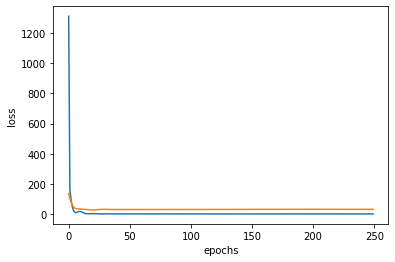

In [74]:
train_loss_history_reduced = [i for idx, i in enumerate(train_loss_history) if idx%2==0]

print(len(train_loss_history_reduced), len(val_loss_history))
plt.plot(list(range(250)), train_loss_history_reduced, '-')
plt.plot(list(range(250)), val_loss_history, '-')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [13]:
overfit_model.double()
overfit_model.cpu()
overfit_model.eval()

image = cv2.imread('DAVIS_2016/DAVIS/Annotations/480p/bear/00001.png')
sample = next(iter(overfit_train_loader))
y = sample.y.detach().numpy()

with torch.no_grad():
    pred = overfit_model(sample).detach().numpy()

contour = np.load('pg_datasets/DAVIS_2016/raw/Contours/bear/00000.npy')

translation_ground_truth = contour + y
translation_pred = contour + pred

In [28]:
def plot_translation(image, translation_ground_truth, translation_pred):
    
    fig, ax = plt.subplots(figsize=(15, 10))
    
    ax.scatter(translation_ground_truth[:, 0], translation_ground_truth[:, 1], color='g')
    ax.scatter(translation_pred[:, 0], translation_pred[:, 1], color='r')
    
    # Plot image
    ax.imshow(image)
    
    ax.axis('image')
    ax.set_xticks([])
    ax.set_yticks([])

    plt.show()

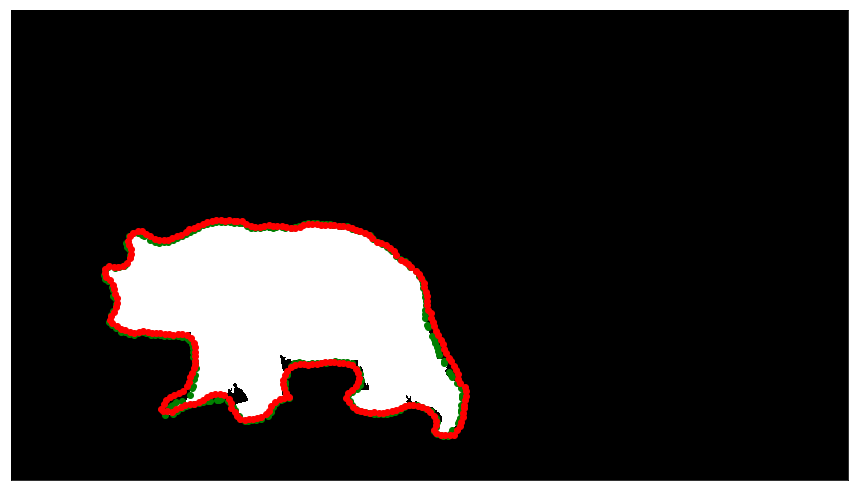

In [29]:
plot_translation(image, translation_ground_truth, translation_pred)

# Train

In [30]:
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)

# Load model and run the solver
model = Net(in_channels=train[0].num_features, 
            out_channels=train[0].y.shape[1])
print(model)
model.double()
model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999), 
                       eps=1e-8, weight_decay=0.0)
train_loss_history = train_net(model, train_loader, optimizer, criterion)

Net(
  (conv1): GCNConv(128, 128)
  (conv2): GCNConv(128, 128)
  (lin1): Linear(in_features=128, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=2, bias=True)
)
START TRAIN.
[1,    10] loss: 1109.76796
[1,    20] loss: 803.80073
[1,    30] loss: 582.18752
[1,    40] loss: 577.90612


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([432])) that is different to the input size (torch.Size([512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (512) must match the size of tensor b (432) at non-singleton dimension 0

In [ ]:
plt.plot(train_loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()

# Validate

In [ ]:
train_loader = DataLoader(train, batch_size=BATCH_SIZE, 
                          shuffle=True, sampler=OverfitSampler)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()